## Apply PhyloVelo to clonal lineage tracing data

We now extend PhyloVelo to clonal lineage tracing data based on static barcodes such as lentiviral barcoding (e.g. LARRY and CellTagging) and T/B cell receptor sequences. Because the cell population size of a uniquely labelled clone at observation indicates its relative proliferation activity in the past division history, we thus used clone size as the surrogate of phylogenetic time in PhyloVelo.

Here is an example of using PhyloVelo to infer intratumor CD8+ T cells cell-fate.

The single-cell TCR and RNA sequencing data of T cells can be accessed through GSE123813. 

In [1]:
import phylovelo as pv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse
import scanpy as sc
import anndata as ad
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plt.rcParams['font.size'] = 12

In [9]:
count = pd.read_csv('/data3/wangkun/phylovelo_datasets/tcr/scRNA_counts.txt', index_col=0, sep='\t').T
metadata = pd.read_csv('/data3/wangkun/phylovelo_datasets/tcr/clonesizeToWangkun.csv', index_col=0)
import re
drop_genes = []
for i in count.columns:
    for num in re.finditer('[0-9]+', i):
        if len(num.group(0)) > 4:
            drop_genes.append(i)
            continue
count = count[count.columns[~np.isin(count.columns, drop_genes)]]

To avoid batch effect, we selected patient9 with most cells to estimate phylogenetic velocity.

In [14]:
patient9_cells = metadata[(metadata.patient=='su009').to_numpy() & (~np.isin(metadata.cluster, ['Tfh', 'Th17', 'Tregs']))].index
sd_p9 = pv.scData(count=count.loc[patient9_cells], Xdr=metadata.loc[patient9_cells][['UMAP1', 'UMAP2']])
sd_p9.drop_duplicate_genes()
sd_p9.normalize_filter()
sd_p9.cell_states = metadata.loc[patient9_cells]['cluster'].to_numpy()

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/data_struct.py:114: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.x_normed = np.divide(self.count, counts_per_cell[:, None])


In [15]:
clonesize = metadata.loc[patient9_cells].clonesizeInCase.to_numpy()
pv.velocity_inference(sd_p9, np.round(np.log(clonesize)), cutoff=0.97, target='x_normed')

  0%|          | 0/12252 [00:00<?, ?it/s]

/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Transfer phylogenetic velocity inferenced in patient9 to all patients

In [18]:
all_Tcells = metadata[~np.isin(metadata.cluster, ['Tfh', 'Th17', 'Tregs']) & (metadata['UMAP1']>-0.5)].index
sd_full = pv.scData(count=count.loc[all_Tcells], Xdr=metadata.loc[all_Tcells][['UMAP1', 'UMAP2']])
sd_full.drop_duplicate_genes()
sd_full.normalize_filter()
sd_full.cell_states = metadata.loc[all_Tcells]['cluster'].to_numpy()
sd_full.x_normed = sd_full.x_normed[sd_p9.x_normed.columns]
sd_full.velocity = sd_p9.velocity

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/data_struct.py:114: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.x_normed = np.divide(self.count, counts_per_cell[:, None])


In [19]:
pv.velocity_embedding(sd_full, target='x_normed', n_neigh=1000)

  0%|          | 0/13132 [00:00<?, ?it/s]

In [28]:
pv.calc_phylo_pseudotime(sd_full, r_sample=0.05, n_neighbors=100)

  0%|          | 0/638 [00:00<?, ?it/s]

In [21]:
color_map = {'CD8_act':'#5b91c0',
             'CD8_eff':'#b6dba5',
             'CD8_ex':'#d75859',
             'CD8_ex_act':'#eaa058',
             'CD8_mem':'#6ac6d3',
             'Naive':'#939aa1'}

<AxesSubplot: xlabel='UMAP 1', ylabel='UMAP 2'>

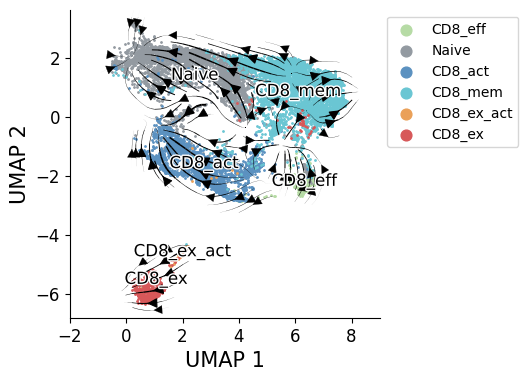

In [26]:
fig, ax = plt.subplots()
for i in set(sd_full.cell_states):
    ax.scatter(sd_full.Xdr.iloc[np.array(sd_full.cell_states)==i, 0], sd_full.Xdr.iloc[np.array(sd_full.cell_states)==i, 1], s=1, label=i, c=color_map[i])
    
ax = pv.velocity_plot(sd_full.Xdr.to_numpy(), sd_full.velocity_embeded, ax, 'stream',streamdensity=1.4, grid_density=40, radius=0.4, lw_coef=8000, arrowsize=1.5)
ax.figure.set_size_inches(4, 4)

ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
lgnd = ax.legend(bbox_to_anchor=(1,1), fontsize=10, loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in lgnd.legendHandles:
    i._sizes = [60]
ax.set_xlim(-2,9)
pv.label_name(sd_full.Xdr.to_numpy(), sd_full.cell_states, ax)

(-2.0, 9.0)

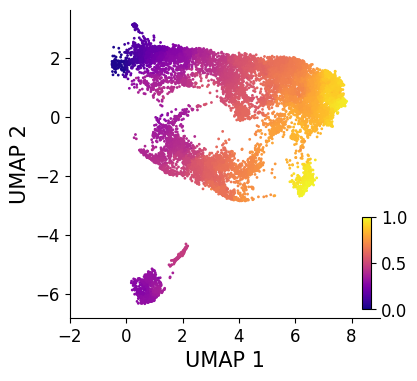

In [29]:
fig, ax = plt.subplots()
scatter=ax.scatter(sd_full.Xdr.iloc[:, 0], sd_full.Xdr.iloc[:, 1], c=sd_full.phylo_pseudotime, s=1, cmap='plasma')
ax.figure.set_size_inches(4, 4)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.set_xlim(-2,9)

Applying Dynamo

In [30]:
import dynamo as dyn

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/wangkun/miniconda3/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [32]:
adata = ad.AnnData(sd_full.x_normed)
adata.obs['cell_states'] = sd_full.cell_states
adata.obsm['X_umap'] = sd_full.Xdr.to_numpy()

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


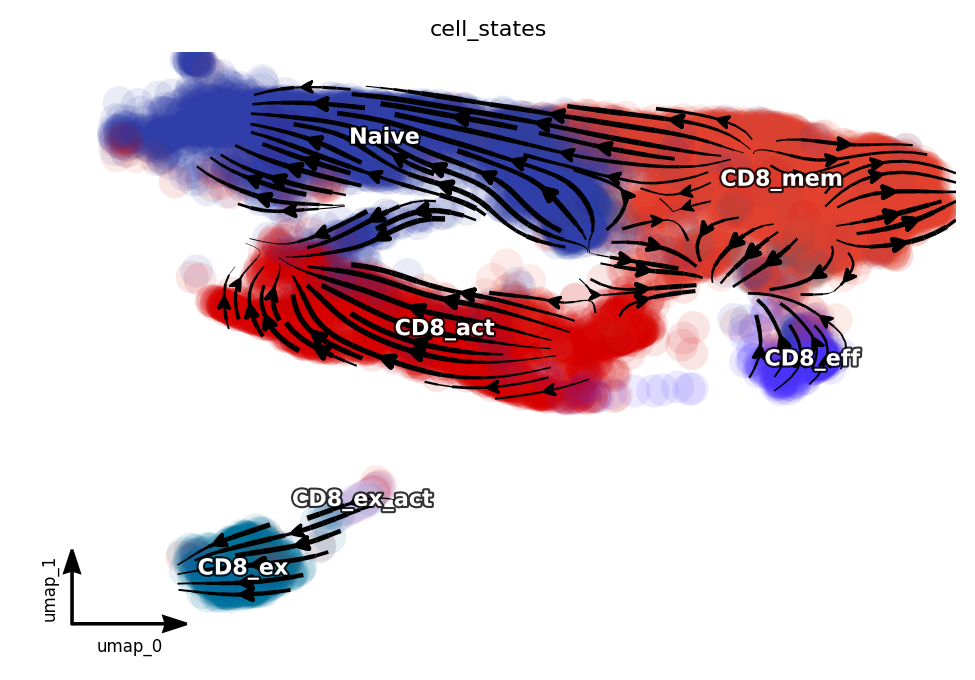

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [2.1077s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] in progress: 100.00

Calculating 2-D curl: 100%|██████████| 12788/12788 [00:00<00:00, 19388.68it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 13/13 [00:00<00:00, 22.04it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.


|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [109.8231s]


/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----------> not all cells are used, set diag to 1...
|-----------> Constructing W matrix according upsampling=True and downsampling=True options...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [65.1587s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f6067486910>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f609ddb9e50>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/home/wangkun/miniconda3/lib/python3.9/site-packages/dynamo/plot/topography.py:533: UserWarning: You passed a edge

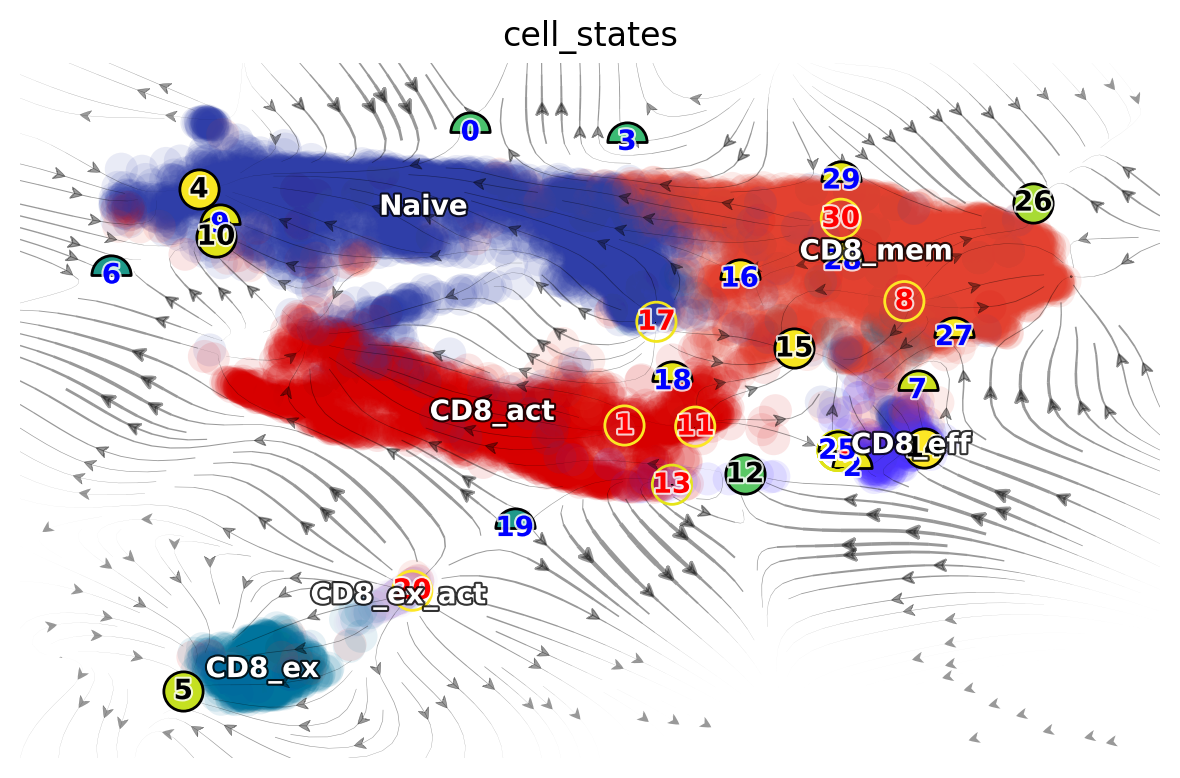

In [33]:
adata.obsm['velocity_umap'] = sd_full.velocity_embeded
dyn.pl.streamline_plot(adata, color=['cell_states'], basis='umap', show_legend='on data', show_arrowed_spines=True)
dyn.vf.VectorField(adata, basis='umap', M=1000, pot_curl_div=True)
dyn.vf.topography(adata, basis='umap')
dyn.ext.ddhodge(adata, basis='umap')
dyn.pl.topography(adata,color='cell_states')

In [40]:
dyn.pd.state_graph(adata, group='cell_states', basis='umap', method='vf', approx=False)

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0030s]
|-----> [iterate groups] in progress: 16.6667%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 344.62it/s]


|-----> [iterate groups] in progress: 33.3333%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 350.65it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 343.40it/s]


|-----> [iterate groups] in progress: 66.6667%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 323.00it/s]


|-----> [iterate groups] in progress: 83.3333%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 310.89it/s]


|-----> [iterate groups] in progress: 100.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 338.95it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [5.0955s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0020s]


AnnData object with n_obs × n_vars = 12788 × 12252
    obs: 'cell_states', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap'
    uns: 'cell_states_colors', 'VecFld_umap', 'cell_states_graph'
    obsm: 'X_umap', 'velocity_umap', 'velocity_umap_SparseVFC', 'X_umap_SparseVFC'

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

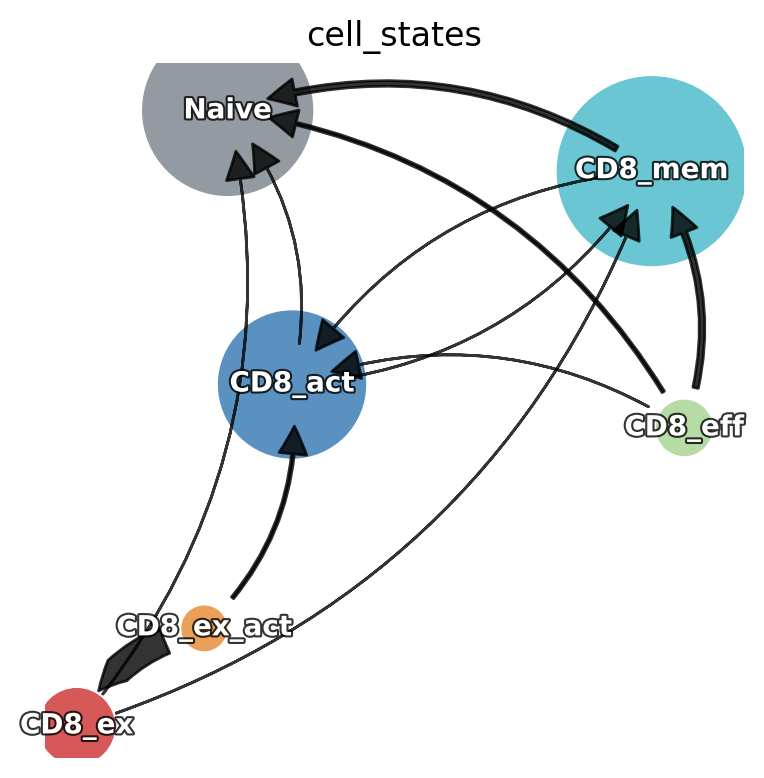

In [41]:
ax = dyn.pl.state_graph(adata,
                        color=['cell_states'],
                        group='cell_states',
                        basis='umap',
                        show_legend='on data',
                        method='vf',
                        figsize=(4,4),
                        edge_scale=0.8,
                        color_key=color_map,
                        save_show_or_return='show',  
                        stack_colors_title =None,
                        graph_alpha=0.8*np.ones((12,12))
                  )
# ax=ax[0]
# ax.set_ylim(-6.3, 10)
# ax.set_xlim(-10, 5)

In [42]:
transition_mat = adata.uns['cell_states_graph']['group_graph']
transition_groups = adata.uns['cell_states_graph']['group_names']
transition_mat = pd.DataFrame(transition_mat, index=transition_groups, columns=transition_groups)
order = ['Naive', 'CD8_act', 'CD8_ex', 'CD8_ex_act', 'CD8_mem', 'CD8_eff']
sel_transitmat = transition_mat[order].loc[order]
sel_transitmat = np.round(sel_transitmat,2)
sel_transitmat = sel_transitmat / sel_transitmat.sum(axis=1)

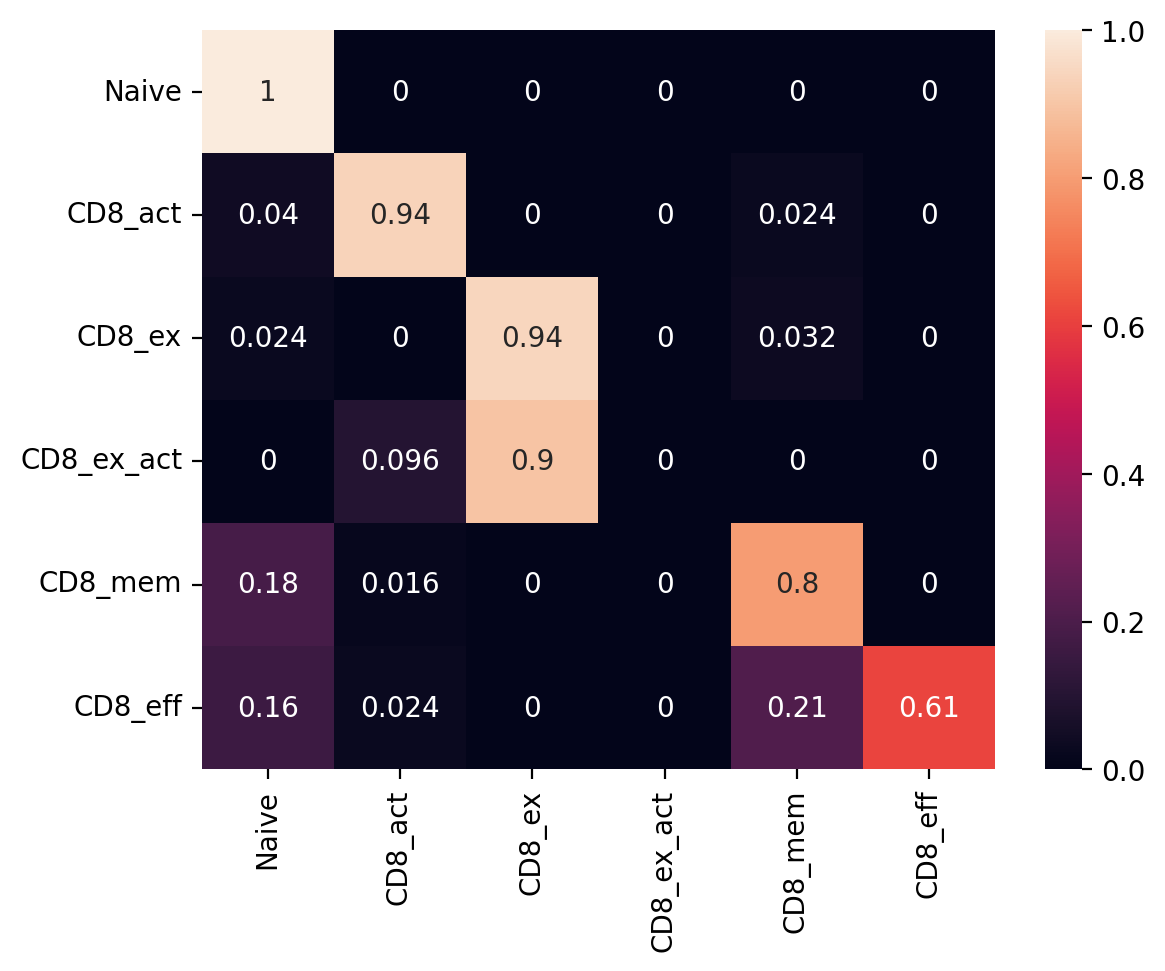

In [43]:
import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(sel_transitmat, annot=True, ax=ax)
plt.show()